**https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo**

In [ ]:
 ! pip install -q kaggle
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jihyeseo/online-retail-data-set-from-uci-ml-repo
!unzip online-retail-data-set-from-uci-ml-repo.zip

 46% 10.0M/21.8M [00:00<00:00, 32.4MB/s]
100% 21.8M/21.8M [00:00<00:00, 57.7MB/s]
Archive:  online-retail-data-set-from-uci-ml-repo.zip
  inflating: Online Retail.xlsx      


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('/content/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#EDA

In [ ]:
df.shape

(541909, 8)

In [ ]:
#check missing values
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [ ]:
#check duplicated values
print(df.duplicated().sum())
print(df.duplicated().mean()*100)

5268
0.9721189350979592


In [ ]:
print(df['CustomerID'].nunique())

4372


In [ ]:
print((df['Country'].nunique()))

38


<Axes: ylabel='CustomerID'>

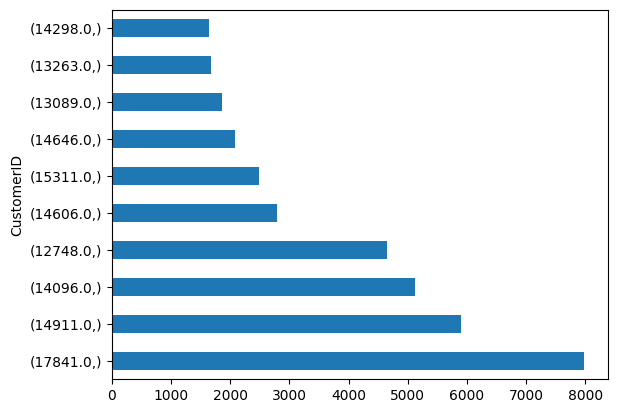

In [ ]:
df[['CustomerID']].value_counts()[:10].plot(kind='barh')

<Axes: >

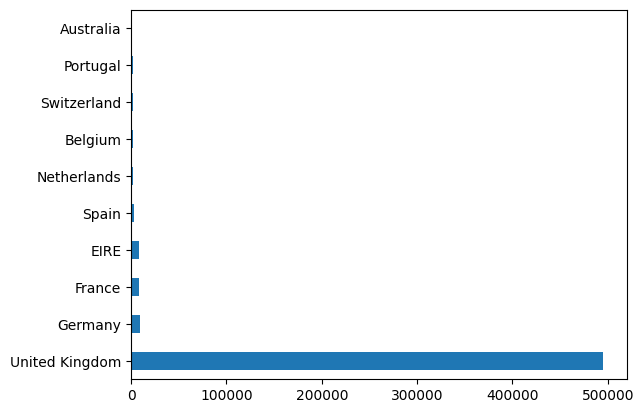

In [ ]:
df.Country.value_counts()[:10].plot(kind='barh')

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#Data Cleaning

In [ ]:
#Removing Quantity & UnitPrice that are less than 0 or negative values
df_rm_neg = df[(df['Quantity']>0) & (df['UnitPrice']>0)]

In [ ]:
print(df_rm_neg.shape)
print(df_rm_neg.describe())

(530104, 8)
            Quantity      UnitPrice     CustomerID
count  530104.000000  530104.000000  397884.000000
mean       10.542037       3.907625   15294.423453
std       155.524124      35.915681    1713.141560
min         1.000000       0.001000   12346.000000
25%         1.000000       1.250000   13969.000000
50%         3.000000       2.080000   15159.000000
75%        10.000000       4.130000   16795.000000
max     80995.000000   13541.330000   18287.000000


In [ ]:
#drop missing value
df_rm_neg = df_rm_neg.dropna()

In [ ]:
df_rm_neg.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#Data Pre-processing

In [ ]:
#change columns InvoiceDate to datedtime type
df_rm_neg['InvoiceDate'] = pd.to_datetime(df_rm_neg['InvoiceDate'])

In [ ]:
df_rm_neg.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [ ]:
#Calculate TotalPrice by Quantity * UnitPrice
df_rm_neg['TotalPrice'] = df_rm_neg['Quantity']*df_rm_neg['UnitPrice']
df_rm_neg.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
#Caculate Snapshot using recent or max date
from datetime import timedelta
snapshot_date = (df_rm_neg['InvoiceDate'].max() + timedelta(days=1))
print('Last Invoice Date:', df_rm_neg['InvoiceDate'].max())
print('Recency/Snapshot Date:', snapshot_date)

Last Invoice Date: 2011-12-09 12:50:00
Recency/Snapshot Date: 2011-12-10 12:50:00


#RFM Customer Segamentation

In [ ]:
RFM = df_rm_neg.groupby(['CustomerID']).agg({
    'InvoiceDate':lambda x:(snapshot_date-x.max()).days,
    'InvoiceNo':'count',
    'TotalPrice':'sum'
})
RFM.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'MonetaryValue'}, inplace=True)
RFM.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


##Plot Distribution

<ipython-input-98-a44bf7765a43>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,2);
<ipython-input-98-a44bf7765a43>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,3);


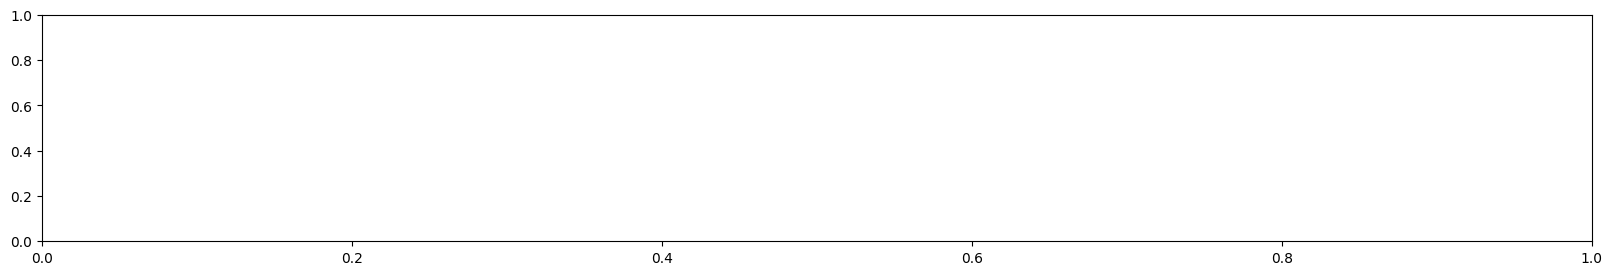

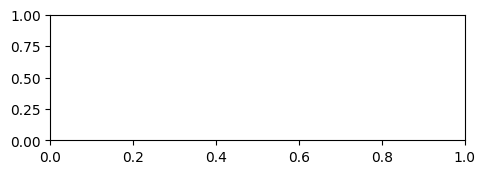

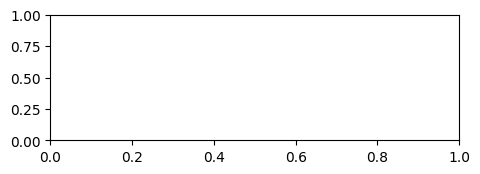

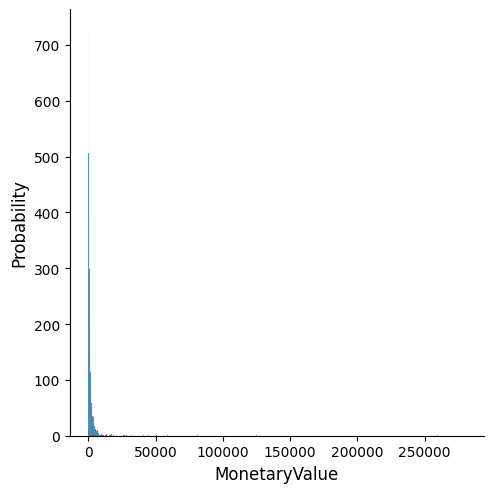

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(3,1,1);
sns.displot(RFM['Recency'])
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Recency', fontsize=12)

plt.subplot(3,1,2);
sns.displot(RFM['Frequency'])
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Frequency', fontsize=12)

plt.subplot(3,1,3);
sns.displot(RFM['MonetaryValue'])
plt.ylabel('Probability', fontsize=12)
plt.xlabel('MonetaryValue', fontsize=12)
plt.show()

In [ ]:
Rlabel = range(4,0,-1)
Flabel = range(1,5)
Mlabel = range(1,5)

Rgrp = pd.qcut(RFM['Recency'], q=4, labels = Rlabel)
Fgrp = pd.qcut(RFM['Frequency'], q=4, labels = Flabel)
Mgrp = pd.qcut(RFM['MonetaryValue'], q=4, labels = Mlabel)

RFM['R'] = Rgrp.values
RFM['F'] = Fgrp.values
RFM['M'] = Mgrp.values

In [ ]:
RFM.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


In [ ]:
RFM['RFM'] = RFM.apply(lambda x : str(x['R']) + str(x['F']) + str(x['M']), axis=1)
RFM.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,114
12347.0,2,182,4310.00,4,4,4,444
12348.0,75,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,310,17,334.40,1,1,2,112


In [ ]:
RFM['Score'] = RFM[['R', 'F', 'M']].sum(axis=1)
RFM.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM,Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


In [ ]:
print('Score Max:', RFM['Score'].max(), 'Score Min:',RFM['Score'].min())

Score Max: 12 Score Min: 3


<Axes: xlabel='Score', ylabel='count'>

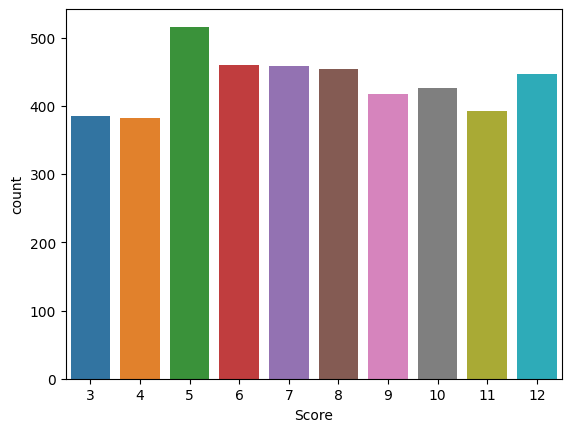

In [ ]:
sns.countplot(x='Score', data=RFM)

#ref: https://sprabasankar.medium.com/machine-learning-algorithm-rfm-model-efd543228a1e